In [1]:
import sys
sys.path.append('../../Share/')
sys.path.append('../../V5 Self Supervised Learning')

import pandas as pd
import numpy as np
from sklearn.utils import resample
import matplotlib.pyplot as plt
import baseline, config, self_supervised_v1

import warnings
warnings.filterwarnings('ignore')

def evaluate_model(model, data, labels):
    return model.evaluate(data, labels, verbose=0)[1]


def down_sample(X, y):
    X = np.array(X)
    y = np.array(y)

    # 클래스별 최소 개수
    unique_classes, counts = np.unique(y, return_counts=True)
    min_count = counts.min()

    X_balanced, y_balanced = [], []

    for cls in unique_classes:
        idx = np.where(y == cls)[0]  # 해당 클래스 인덱스
        down_idx = resample(idx, replace=False, n_samples=min_count, random_state=42)
        X_balanced.append(X[down_idx])
        y_balanced.append(y[down_idx])

    # 합치기
    X_balanced = np.concatenate(X_balanced, axis=0)
    y_balanced = np.concatenate(y_balanced, axis=0)

    return X_balanced, y_balanced



trainer_Minjeong = baseline.ModelTrainer(config, subject="Minjeong")
trainer_Carlson = baseline.ModelTrainer(config, subject="Carlson")
trainer_Harold = baseline.ModelTrainer(config, subject="Harold")
trainer_Hunmin = baseline.ModelTrainer(config, subject="Hunmin")
trainer_Brian = baseline.ModelTrainer(config, subject="Brian")
trainer_Xianyu = baseline.ModelTrainer(config, subject="Xianyu")

In [2]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import meta

trainers_unseen = {
    "H": trainer_Hunmin,
    "C": trainer_Carlson,
    "B": trainer_Brian,
    "X": trainer_Xianyu,
    "M": trainer_Minjeong
}
#Same_Session_Test_Acc, Next_Session_Test_Acc = [], []
#Unseen_subject_acc_dict = {"H": [], "C": [], "B": [], "X": [], "M": []}
n_classes = 6

In [3]:
Harold_CM = []

In [6]:
model = load_model('./model_K10_H2.h5')
model.compile(optimizer=Adam(learning_rate=0.05), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

trainer_sub, final_session = trainer_Minjeong, len(config.Info_sub_M)
X_TEST, y_TEST, _, _ = trainer_sub.return_K_th_data_only(K=final_session-1, train_ratio=0.99)
X_TEST, y_TEST = down_sample(X_TEST, y_TEST)
Acc_lst = []

cm_total = np.zeros((n_classes, n_classes), dtype=np.int32)
best_acc = -1
best_cm = None

for k in range(10):
    unseen_X, unseen_y, X_few_shot, y_few_shot = trainer_sub.return_K_th_data_only(K=k, train_ratio=0.8)
    X_train, y_train = down_sample(unseen_X, unseen_y)
    X_test, y_test = down_sample(X_few_shot, y_few_shot)

    Meta = meta.MetaLearner(input_model=model, N_way=6, input_shape=X_train.shape[1:], meta_iters=5, meta_step_size=1)
    acc, y_pred = Meta.train_for_heatmap(X_train, y_train, X_TEST, y_TEST, meta.get_data_Meta, N_way=6, K_shot=20)
    print(f"Run {k} | Acc: {acc:.4f}")
    Acc_lst.append(acc)

    if acc > best_acc:  # 현재까지 최고 acc면 confusion matrix 갱신
        best_acc = acc
        best_cm = confusion_matrix(y_TEST, y_pred, labels=np.arange(n_classes))

# 최종 confusion matrix (best run)
if best_cm is not None:
    cm_total += best_cm
    cm_norm = best_cm.astype('float') / best_cm.sum(axis=1)[:, np.newaxis]  # row-normalized
    Harold_CM.append(cm_total)

Returning K-th session data: Exp_2025-08-15-v2/E9AD0E7DCC2B/
Returning K-th session data: Exp_2025-08-01-v1/E9AD0E7DCC2B/
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Run 0 | Acc: 0.5917
Returning K-th session data: Exp_2025-08-01-v2/E9AD0E7DCC2B/
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Run 1 | Acc: 0.5750
Returning K-th session data: Exp_2025-08-02-v1/E9AD0E7DCC2B/
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Run 2 | Acc: 0.5500
Returning K-th session data: Exp_2025-08-02-v2/E9AD0E7DCC2B/
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Run 3 | Acc: 0.6000
Returning K-th session data: Exp_2025-08-09-v1/E9AD0E7DCC2B/
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Run 4 | Acc: 0.6333
Returning K-th session data: Exp_2025-08-09-v2/E9AD0E7DCC2B/
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Run 5 | Acc: 0.7000
Returning K-th session data: Exp_2025-08-10-v1/E9AD0E7DCC2B/
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Run 6 | Acc: 0.7500
Returning K-th session data: Exp_2025-08-10-v2/E9AD0E7DCC2B/
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/s

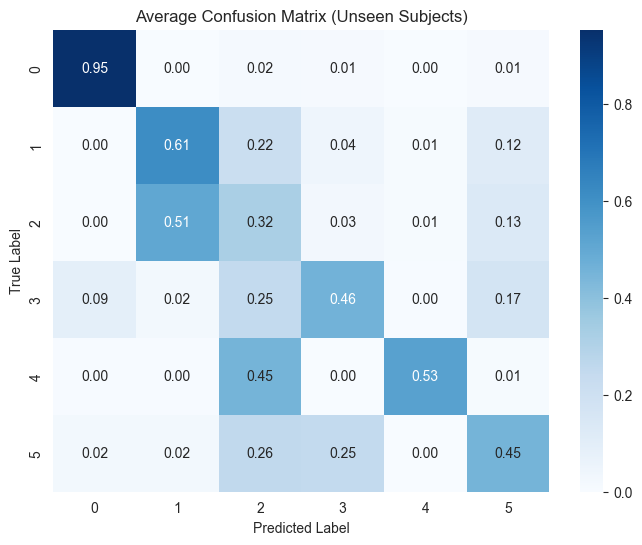

In [9]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=np.arange(n_classes),
            yticklabels=np.arange(n_classes))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Average Confusion Matrix (Unseen Subjects)")
plt.show()

In [ ]:
model = load_model('./model_K10_H2.h5')
model.compile(optimizer=Adam(learning_rate=0.05), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

trainer_sub, final_session = trainer_Brian, len(config.Info_sub_B)
X_TEST, y_TEST, _, _ = trainer_sub.return_K_th_data_only(K=final_session-1, train_ratio=0.99)
X_TEST, y_TEST = down_sample(X_TEST, y_TEST)
Acc_lst = []

for k in range(10):
    unseen_X, unseen_y, X_few_shot, y_few_shot = trainer_sub.return_K_th_data_only(K=k, train_ratio=0.8)
    X_train, y_train = down_sample(unseen_X, unseen_y)
    X_test, y_test = down_sample(X_few_shot, y_few_shot)

    Meta = meta.MetaLearner(input_model=model, N_way=6, input_shape=X_train.shape[1:],
        meta_iters=5,                              # Number of meta-training loops
        meta_step_size=1                          # Reptile meta step
    )

    acc = Meta.train(X_train, y_train, X_TEST, y_TEST, meta.get_data_Meta, N_way=6, K_shot=20)
    print(acc)
    Acc_lst.append(acc)

# Hunmin

In [ ]:
model = load_model('./model_K10_H.h5')
model.compile(optimizer=Adam(learning_rate=1e-2), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

trainer_sub, final_session = trainer_Minjeong, len(config.Info_sub_M)
X_TEST, y_TEST, _, _ = trainer_sub.return_K_th_data_only(K=final_session-1, train_ratio=0.99)
X_TEST, y_TEST = down_sample(X_TEST, y_TEST)
Acc_lst = []

for k in range(10):
    unseen_X, unseen_y, X_few_shot, y_few_shot = trainer_sub.return_K_th_data_only(K=k, train_ratio=0.8)
    X_train, y_train = down_sample(unseen_X, unseen_y)
    X_test, y_test = down_sample(X_few_shot, y_few_shot)

    Meta = meta.MetaLearner(input_model=model, N_way=6, input_shape=X_train.shape[1:],
        meta_iters=5,                              # Number of meta-training loops
        meta_step_size=1                          # Reptile meta step
    )

    acc = Meta.train(X_train, y_train, X_TEST, y_TEST, meta.get_data_Meta, N_way=6, K_shot=20)
    print(acc)
    Acc_lst.append(acc)

In [ ]:
model = load_model('./model_K10_H.h5')
model.compile(optimizer=Adam(learning_rate=1e-2), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

trainer_sub, final_session = trainer_Brian, len(config.Info_sub_B)
X_TEST, y_TEST, _, _ = trainer_sub.return_K_th_data_only(K=final_session-1, train_ratio=0.99)
X_TEST, y_TEST = down_sample(X_TEST, y_TEST)
Acc_lst = []

for k in range(10):
    unseen_X, unseen_y, X_few_shot, y_few_shot = trainer_sub.return_K_th_data_only(K=k, train_ratio=0.8)
    X_train, y_train = down_sample(unseen_X, unseen_y)
    X_test, y_test = down_sample(X_few_shot, y_few_shot)

    Meta = meta.MetaLearner(input_model=model, N_way=6, input_shape=X_train.shape[1:],
        meta_iters=5,                              # Number of meta-training loops
        meta_step_size=1                          # Reptile meta step
    )

    acc = Meta.train(X_train, y_train, X_TEST, y_TEST, meta.get_data_Meta, N_way=6, K_shot=20)
    print(acc)
    Acc_lst.append(acc)

In [ ]:
model = load_model('./model_K10_H.h5')
model.compile(optimizer=Adam(learning_rate=1e-2), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

trainer_sub, final_session = trainer_Xianyu, len(config.Info_sub_X)
X_TEST, y_TEST, _, _ = trainer_sub.return_K_th_data_only(K=final_session-1, train_ratio=0.99)
X_TEST, y_TEST = down_sample(X_TEST, y_TEST)
Acc_lst = []

for k in range(10):
    unseen_X, unseen_y, X_few_shot, y_few_shot = trainer_sub.return_K_th_data_only(K=k, train_ratio=0.8)
    X_train, y_train = down_sample(unseen_X, unseen_y)
    X_test, y_test = down_sample(X_few_shot, y_few_shot)

    Meta = meta.MetaLearner(input_model=model, N_way=6, input_shape=X_train.shape[1:],
        meta_iters=5,                              # Number of meta-training loops
        meta_step_size=1                          # Reptile meta step
    )

    acc = Meta.train(X_train, y_train, X_TEST, y_TEST, meta.get_data_Meta, N_way=6, K_shot=20)
    print(acc)
    Acc_lst.append(acc)

In [ ]:
model = load_model('./model_K10_H.h5')
model.compile(optimizer=Adam(learning_rate=1e-2), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

trainer_sub, final_session = trainer_Carlson, len(config.Info_sub_C)
X_TEST, y_TEST, _, _ = trainer_sub.return_K_th_data_only(K=final_session-1, train_ratio=0.99)
X_TEST, y_TEST = down_sample(X_TEST, y_TEST)
Acc_lst = []

for k in range(10):
    unseen_X, unseen_y, X_few_shot, y_few_shot = trainer_sub.return_K_th_data_only(K=k, train_ratio=0.8)
    X_train, y_train = down_sample(unseen_X, unseen_y)
    X_test, y_test = down_sample(X_few_shot, y_few_shot)

    Meta = meta.MetaLearner(input_model=model, N_way=6, input_shape=X_train.shape[1:],
        meta_iters=5,                              # Number of meta-training loops
        meta_step_size=1                          # Reptile meta step
    )

    acc = Meta.train(X_train, y_train, X_TEST, y_TEST, meta.get_data_Meta, N_way=6, K_shot=20)
    print(acc)
    Acc_lst.append(acc)

In [ ]:
model = load_model('./model_K10_H.h5')
model.compile(optimizer=Adam(learning_rate=1e-2), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

trainer_sub, final_session = trainer_Harold, len(config.Info_sub_H2)
X_TEST, y_TEST, _, _ = trainer_sub.return_K_th_data_only(K=final_session-1, train_ratio=0.99)
X_TEST, y_TEST = down_sample(X_TEST, y_TEST)
Acc_lst = []

for k in range(10):
    unseen_X, unseen_y, X_few_shot, y_few_shot = trainer_sub.return_K_th_data_only(K=k, train_ratio=0.8)
    X_train, y_train = down_sample(unseen_X, unseen_y)
    X_test, y_test = down_sample(X_few_shot, y_few_shot)

    Meta = meta.MetaLearner(input_model=model, N_way=6, input_shape=X_train.shape[1:],
        meta_iters=5,                              # Number of meta-training loops
        meta_step_size=1                          # Reptile meta step
    )

    acc = Meta.train(X_train, y_train, X_TEST, y_TEST, meta.get_data_Meta, N_way=6, K_shot=20)
    print(acc)
    Acc_lst.append(acc)

# Xianyu

In [ ]:
model = load_model('./model_K10_X.h5')
model.compile(optimizer=Adam(learning_rate=1e-2), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

trainer_sub, final_session = trainer_Harold, len(config.Info_sub_H2)
X_TEST, y_TEST, _, _ = trainer_sub.return_K_th_data_only(K=final_session-1, train_ratio=0.99)
X_TEST, y_TEST = down_sample(X_TEST, y_TEST)
Acc_lst = []

for k in range(10):
    unseen_X, unseen_y, X_few_shot, y_few_shot = trainer_sub.return_K_th_data_only(K=k, train_ratio=0.8)
    X_train, y_train = down_sample(unseen_X, unseen_y)
    X_test, y_test = down_sample(X_few_shot, y_few_shot)

    Meta = meta.MetaLearner(input_model=model, N_way=6, input_shape=X_train.shape[1:],
        meta_iters=5,                              # Number of meta-training loops
        meta_step_size=1                          # Reptile meta step
    )

    acc = Meta.train(X_train, y_train, X_TEST, y_TEST, meta.get_data_Meta, N_way=6, K_shot=20)
    print(acc)
    Acc_lst.append(acc)

In [ ]:
model = load_model('./model_K10_X.h5')
model.compile(optimizer=Adam(learning_rate=1e-2), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

trainer_sub, final_session = trainer_Hunmin, len(config.Info_sub_H)
X_TEST, y_TEST, _, _ = trainer_sub.return_K_th_data_only(K=final_session-1, train_ratio=0.99)
X_TEST, y_TEST = down_sample(X_TEST, y_TEST)
Acc_lst = []

for k in range(10):
    unseen_X, unseen_y, X_few_shot, y_few_shot = trainer_sub.return_K_th_data_only(K=k, train_ratio=0.8)
    X_train, y_train = down_sample(unseen_X, unseen_y)
    X_test, y_test = down_sample(X_few_shot, y_few_shot)

    Meta = meta.MetaLearner(input_model=model, N_way=6, input_shape=X_train.shape[1:],
        meta_iters=5,                              # Number of meta-training loops
        meta_step_size=1                          # Reptile meta step
    )

    acc = Meta.train(X_train, y_train, X_TEST, y_TEST, meta.get_data_Meta, N_way=6, K_shot=20)
    print(acc)
    Acc_lst.append(acc)

In [ ]:
model = load_model('./model_K10_X.h5')
model.compile(optimizer=Adam(learning_rate=1e-2), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

trainer_sub, final_session = trainer_Carlson, len(config.Info_sub_C)
X_TEST, y_TEST, _, _ = trainer_sub.return_K_th_data_only(K=final_session-1, train_ratio=0.99)
X_TEST, y_TEST = down_sample(X_TEST, y_TEST)
Acc_lst = []

for k in range(10):
    unseen_X, unseen_y, X_few_shot, y_few_shot = trainer_sub.return_K_th_data_only(K=k, train_ratio=0.8)
    X_train, y_train = down_sample(unseen_X, unseen_y)
    X_test, y_test = down_sample(X_few_shot, y_few_shot)

    Meta = meta.MetaLearner(input_model=model, N_way=6, input_shape=X_train.shape[1:],
        meta_iters=5,                              # Number of meta-training loops
        meta_step_size=1                          # Reptile meta step
    )

    acc = Meta.train(X_train, y_train, X_TEST, y_TEST, meta.get_data_Meta, N_way=6, K_shot=20)
    print(acc)
    Acc_lst.append(acc)

In [ ]:
model = load_model('./model_K10_X.h5')
model.compile(optimizer=Adam(learning_rate=1e-2), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

trainer_sub, final_session = trainer_Brian, len(config.Info_sub_B)
X_TEST, y_TEST, _, _ = trainer_sub.return_K_th_data_only(K=final_session-1, train_ratio=0.99)
X_TEST, y_TEST = down_sample(X_TEST, y_TEST)
Acc_lst = []

for k in range(10):
    unseen_X, unseen_y, X_few_shot, y_few_shot = trainer_sub.return_K_th_data_only(K=k, train_ratio=0.8)
    X_train, y_train = down_sample(unseen_X, unseen_y)
    X_test, y_test = down_sample(X_few_shot, y_few_shot)

    Meta = meta.MetaLearner(input_model=model, N_way=6, input_shape=X_train.shape[1:],
        meta_iters=5,                              # Number of meta-training loops
        meta_step_size=1                          # Reptile meta step
    )

    acc = Meta.train(X_train, y_train, X_TEST, y_TEST, meta.get_data_Meta, N_way=6, K_shot=20)
    print(acc)
    Acc_lst.append(acc)

In [ ]:
model = load_model('./model_K10_X.h5')
model.compile(optimizer=Adam(learning_rate=1e-2), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

trainer_sub, final_session = trainer_Minjeong, len(config.Info_sub_M)
X_TEST, y_TEST, _, _ = trainer_sub.return_K_th_data_only(K=final_session-1, train_ratio=0.99)
X_TEST, y_TEST = down_sample(X_TEST, y_TEST)
Acc_lst = []

for k in range(10):
    unseen_X, unseen_y, X_few_shot, y_few_shot = trainer_sub.return_K_th_data_only(K=k, train_ratio=0.8)
    X_train, y_train = down_sample(unseen_X, unseen_y)
    X_test, y_test = down_sample(X_few_shot, y_few_shot)

    Meta = meta.MetaLearner(input_model=model, N_way=6, input_shape=X_train.shape[1:],
        meta_iters=5,                              # Number of meta-training loops
        meta_step_size=1                          # Reptile meta step
    )

    acc = Meta.train(X_train, y_train, X_TEST, y_TEST, meta.get_data_Meta, N_way=6, K_shot=20)
    print(acc)
    Acc_lst.append(acc)

# Brian

In [ ]:
model = load_model('./model_K10_B.h5')
model.compile(optimizer=Adam(learning_rate=1e-2), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

trainer_sub, final_session = trainer_Minjeong, len(config.Info_sub_M)
X_TEST, y_TEST, _, _ = trainer_sub.return_K_th_data_only(K=final_session-1, train_ratio=0.99)
X_TEST, y_TEST = down_sample(X_TEST, y_TEST)
Acc_lst = []

for k in range(10):
    unseen_X, unseen_y, X_few_shot, y_few_shot = trainer_sub.return_K_th_data_only(K=k, train_ratio=0.8)
    X_train, y_train = down_sample(unseen_X, unseen_y)
    X_test, y_test = down_sample(X_few_shot, y_few_shot)

    Meta = meta.MetaLearner(input_model=model, N_way=6, input_shape=X_train.shape[1:],
        meta_iters=5,                              # Number of meta-training loops
        meta_step_size=1                          # Reptile meta step
    )

    acc = Meta.train(X_train, y_train, X_TEST, y_TEST, meta.get_data_Meta, N_way=6, K_shot=20)
    print(acc)
    Acc_lst.append(acc)

In [ ]:
model = load_model('./model_K10_B.h5')
model.compile(optimizer=Adam(learning_rate=1e-2), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

trainer_sub, final_session = trainer_Hunmin, len(config.Info_sub_H)
X_TEST, y_TEST, _, _ = trainer_sub.return_K_th_data_only(K=final_session-1, train_ratio=0.99)
X_TEST, y_TEST = down_sample(X_TEST, y_TEST)
Acc_lst = []

for k in range(10):
    unseen_X, unseen_y, X_few_shot, y_few_shot = trainer_sub.return_K_th_data_only(K=k, train_ratio=0.8)
    X_train, y_train = down_sample(unseen_X, unseen_y)
    X_test, y_test = down_sample(X_few_shot, y_few_shot)

    Meta = meta.MetaLearner(input_model=model, N_way=6, input_shape=X_train.shape[1:],
        meta_iters=5,                              # Number of meta-training loops
        meta_step_size=1                          # Reptile meta step
    )

    acc = Meta.train(X_train, y_train, X_TEST, y_TEST, meta.get_data_Meta, N_way=6, K_shot=20)
    print(acc)
    Acc_lst.append(acc)

In [ ]:
model = load_model('./model_K10_B.h5')
model.compile(optimizer=Adam(learning_rate=1e-2), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

trainer_sub, final_session = trainer_Harold, len(config.Info_sub_H2)
X_TEST, y_TEST, _, _ = trainer_sub.return_K_th_data_only(K=final_session-1, train_ratio=0.99)
X_TEST, y_TEST = down_sample(X_TEST, y_TEST)
Acc_lst = []

for k in range(10):
    unseen_X, unseen_y, X_few_shot, y_few_shot = trainer_sub.return_K_th_data_only(K=k, train_ratio=0.8)
    X_train, y_train = down_sample(unseen_X, unseen_y)
    X_test, y_test = down_sample(X_few_shot, y_few_shot)

    Meta = meta.MetaLearner(input_model=model, N_way=6, input_shape=X_train.shape[1:],
        meta_iters=5,                              # Number of meta-training loops
        meta_step_size=1                          # Reptile meta step
    )

    acc = Meta.train(X_train, y_train, X_TEST, y_TEST, meta.get_data_Meta, N_way=6, K_shot=20)
    print(acc)
    Acc_lst.append(acc)

In [ ]:
model = load_model('./model_K10_B.h5')
model.compile(optimizer=Adam(learning_rate=1e-2), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

trainer_sub, final_session = trainer_Xianyu, len(config.Info_sub_X)
X_TEST, y_TEST, _, _ = trainer_sub.return_K_th_data_only(K=final_session-1, train_ratio=0.99)
X_TEST, y_TEST = down_sample(X_TEST, y_TEST)
Acc_lst = []

for k in range(10):
    unseen_X, unseen_y, X_few_shot, y_few_shot = trainer_sub.return_K_th_data_only(K=k, train_ratio=0.8)
    X_train, y_train = down_sample(unseen_X, unseen_y)
    X_test, y_test = down_sample(X_few_shot, y_few_shot)

    Meta = meta.MetaLearner(input_model=model, N_way=6, input_shape=X_train.shape[1:],
        meta_iters=5,                              # Number of meta-training loops
        meta_step_size=1                          # Reptile meta step
    )

    acc = Meta.train(X_train, y_train, X_TEST, y_TEST, meta.get_data_Meta, N_way=6, K_shot=20)
    print(acc)
    Acc_lst.append(acc)

In [ ]:
model = load_model('./model_K10_B.h5')
model.compile(optimizer=Adam(learning_rate=1e-2), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

trainer_sub, final_session = trainer_Carlson, len(config.Info_sub_C)
X_TEST, y_TEST, _, _ = trainer_sub.return_K_th_data_only(K=final_session-1, train_ratio=0.99)
X_TEST, y_TEST = down_sample(X_TEST, y_TEST)
Acc_lst = []

for k in range(10):
    unseen_X, unseen_y, X_few_shot, y_few_shot = trainer_sub.return_K_th_data_only(K=k, train_ratio=0.8)
    X_train, y_train = down_sample(unseen_X, unseen_y)
    X_test, y_test = down_sample(X_few_shot, y_few_shot)

    Meta = meta.MetaLearner(input_model=model, N_way=6, input_shape=X_train.shape[1:],
        meta_iters=5,                              # Number of meta-training loops
        meta_step_size=1                          # Reptile meta step
    )

    acc = Meta.train(X_train, y_train, X_TEST, y_TEST, meta.get_data_Meta, N_way=6, K_shot=20)
    print(acc)
    Acc_lst.append(acc)

# Carlson

In [ ]:
model = load_model('./model_K10_C.h5')
model.compile(optimizer=Adam(learning_rate=1e-2), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

trainer_sub, final_session = trainer_Harold, len(config.Info_sub_H2)
X_TEST, y_TEST, _, _ = trainer_sub.return_K_th_data_only(K=final_session-1, train_ratio=0.99)
X_TEST, y_TEST = down_sample(X_TEST, y_TEST)
Acc_lst = []

for k in range(10):
    unseen_X, unseen_y, X_few_shot, y_few_shot = trainer_sub.return_K_th_data_only(K=k, train_ratio=0.8)
    X_train, y_train = down_sample(unseen_X, unseen_y)
    X_test, y_test = down_sample(X_few_shot, y_few_shot)

    Meta = meta.MetaLearner(input_model=model, N_way=6, input_shape=X_train.shape[1:],
        meta_iters=5,                              # Number of meta-training loops
        meta_step_size=1                          # Reptile meta step
    )

    acc = Meta.train(X_train, y_train, X_TEST, y_TEST, meta.get_data_Meta, N_way=6, K_shot=20)
    print(acc)
    Acc_lst.append(acc)

In [ ]:
model = load_model('./model_K10_C.h5')
model.compile(optimizer=Adam(learning_rate=1e-2), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

trainer_sub, final_session = trainer_Hunmin, len(config.Info_sub_H)
X_TEST, y_TEST, _, _ = trainer_sub.return_K_th_data_only(K=final_session-1, train_ratio=0.99)
X_TEST, y_TEST = down_sample(X_TEST, y_TEST)
Acc_lst = []

for k in range(10):
    unseen_X, unseen_y, X_few_shot, y_few_shot = trainer_sub.return_K_th_data_only(K=k, train_ratio=0.8)
    X_train, y_train = down_sample(unseen_X, unseen_y)
    X_test, y_test = down_sample(X_few_shot, y_few_shot)

    Meta = meta.MetaLearner(input_model=model, N_way=6, input_shape=X_train.shape[1:],
        meta_iters=5,                              # Number of meta-training loops
        meta_step_size=1                          # Reptile meta step
    )

    acc = Meta.train(X_train, y_train, X_TEST, y_TEST, meta.get_data_Meta, N_way=6, K_shot=20)
    print(acc)
    Acc_lst.append(acc)

In [ ]:
model = load_model('./model_K10_C.h5')
model.compile(optimizer=Adam(learning_rate=1e-2), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

trainer_sub, final_session = trainer_Brian, len(config.Info_sub_B)
X_TEST, y_TEST, _, _ = trainer_sub.return_K_th_data_only(K=final_session-1, train_ratio=0.99)
X_TEST, y_TEST = down_sample(X_TEST, y_TEST)
Acc_lst = []

for k in range(10):
    unseen_X, unseen_y, X_few_shot, y_few_shot = trainer_sub.return_K_th_data_only(K=k, train_ratio=0.8)
    X_train, y_train = down_sample(unseen_X, unseen_y)
    X_test, y_test = down_sample(X_few_shot, y_few_shot)

    Meta = meta.MetaLearner(input_model=model, N_way=6, input_shape=X_train.shape[1:],
        meta_iters=5,                              # Number of meta-training loops
        meta_step_size=1                          # Reptile meta step
    )

    acc = Meta.train(X_train, y_train, X_TEST, y_TEST, meta.get_data_Meta, N_way=6, K_shot=20)
    print(acc)
    Acc_lst.append(acc)

In [ ]:
model = load_model('./model_K10_C.h5')
model.compile(optimizer=Adam(learning_rate=1e-2), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

trainer_sub, final_session = trainer_Xianyu, len(config.Info_sub_X)
X_TEST, y_TEST, _, _ = trainer_sub.return_K_th_data_only(K=final_session-1, train_ratio=0.99)
X_TEST, y_TEST = down_sample(X_TEST, y_TEST)
Acc_lst = []

for k in range(10):
    unseen_X, unseen_y, X_few_shot, y_few_shot = trainer_sub.return_K_th_data_only(K=k, train_ratio=0.8)
    X_train, y_train = down_sample(unseen_X, unseen_y)
    X_test, y_test = down_sample(X_few_shot, y_few_shot)

    Meta = meta.MetaLearner(input_model=model, N_way=6, input_shape=X_train.shape[1:],
        meta_iters=5,                              # Number of meta-training loops
        meta_step_size=1                          # Reptile meta step
    )

    acc = Meta.train(X_train, y_train, X_TEST, y_TEST, meta.get_data_Meta, N_way=6, K_shot=20)
    print(acc)
    Acc_lst.append(acc)

In [ ]:
model = load_model('./model_K10_C.h5')
model.compile(optimizer=Adam(learning_rate=1e-2), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

trainer_sub, final_session = trainer_Minjeong, len(config.Info_sub_M)
X_TEST, y_TEST, _, _ = trainer_sub.return_K_th_data_only(K=final_session-1, train_ratio=0.99)
X_TEST, y_TEST = down_sample(X_TEST, y_TEST)
Acc_lst = []

for k in range(10):
    unseen_X, unseen_y, X_few_shot, y_few_shot = trainer_sub.return_K_th_data_only(K=k, train_ratio=0.8)
    X_train, y_train = down_sample(unseen_X, unseen_y)
    X_test, y_test = down_sample(X_few_shot, y_few_shot)

    Meta = meta.MetaLearner(input_model=model, N_way=6, input_shape=X_train.shape[1:],
        meta_iters=5,                              # Number of meta-training loops
        meta_step_size=1                          # Reptile meta step
    )

    acc = Meta.train(X_train, y_train, X_TEST, y_TEST, meta.get_data_Meta, N_way=6, K_shot=20)
    print(acc)
    Acc_lst.append(acc)

# Minjeong

In [ ]:
model = load_model('./model_K10_M.h5')
model.compile(optimizer=Adam(learning_rate=1e-2), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

trainer_sub, final_session = trainer_Xianyu, len(config.Info_sub_X)
X_TEST, y_TEST, _, _ = trainer_sub.return_K_th_data_only(K=final_session-1, train_ratio=0.99)
X_TEST, y_TEST = down_sample(X_TEST, y_TEST)
Acc_lst = []

for k in range(10):
    unseen_X, unseen_y, X_few_shot, y_few_shot = trainer_sub.return_K_th_data_only(K=k, train_ratio=0.8)
    X_train, y_train = down_sample(unseen_X, unseen_y)
    X_test, y_test = down_sample(X_few_shot, y_few_shot)

    Meta = meta.MetaLearner(input_model=model, N_way=6, input_shape=X_train.shape[1:],
        meta_iters=5,                              # Number of meta-training loops
        meta_step_size=1                          # Reptile meta step
    )

    acc = Meta.train(X_train, y_train, X_TEST, y_TEST, meta.get_data_Meta, N_way=6, K_shot=20)
    print(acc)
    Acc_lst.append(acc)

In [ ]:
model = load_model('./model_K10_M.h5')
model.compile(optimizer=Adam(learning_rate=1e-2), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

trainer_sub, final_session = trainer_Hunmin, len(config.Info_sub_H)
X_TEST, y_TEST, _, _ = trainer_sub.return_K_th_data_only(K=final_session-1, train_ratio=0.99)
X_TEST, y_TEST = down_sample(X_TEST, y_TEST)
Acc_lst = []

for k in range(10):
    unseen_X, unseen_y, X_few_shot, y_few_shot = trainer_sub.return_K_th_data_only(K=k, train_ratio=0.8)
    X_train, y_train = down_sample(unseen_X, unseen_y)
    X_test, y_test = down_sample(X_few_shot, y_few_shot)

    Meta = meta.MetaLearner(input_model=model, N_way=6, input_shape=X_train.shape[1:],
        meta_iters=5,                              # Number of meta-training loops
        meta_step_size=1                          # Reptile meta step
    )

    acc = Meta.train(X_train, y_train, X_TEST, y_TEST, meta.get_data_Meta, N_way=6, K_shot=20)
    print(acc)
    Acc_lst.append(acc)

In [ ]:
model = load_model('./model_K10_M.h5')
model.compile(optimizer=Adam(learning_rate=1e-2), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

trainer_sub, final_session = trainer_Harold, len(config.Info_sub_H2)
X_TEST, y_TEST, _, _ = trainer_sub.return_K_th_data_only(K=final_session-1, train_ratio=0.99)
X_TEST, y_TEST = down_sample(X_TEST, y_TEST)
Acc_lst = []

for k in range(10):
    unseen_X, unseen_y, X_few_shot, y_few_shot = trainer_sub.return_K_th_data_only(K=k, train_ratio=0.8)
    X_train, y_train = down_sample(unseen_X, unseen_y)
    X_test, y_test = down_sample(X_few_shot, y_few_shot)

    Meta = meta.MetaLearner(input_model=model, N_way=6, input_shape=X_train.shape[1:],
        meta_iters=5,                              # Number of meta-training loops
        meta_step_size=1                          # Reptile meta step
    )

    acc = Meta.train(X_train, y_train, X_TEST, y_TEST, meta.get_data_Meta, N_way=6, K_shot=20)
    print(acc)
    Acc_lst.append(acc)

In [ ]:
model = load_model('./model_K10_M.h5')
model.compile(optimizer=Adam(learning_rate=1e-2), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

trainer_sub, final_session = trainer_Brian, len(config.Info_sub_B)
X_TEST, y_TEST, _, _ = trainer_sub.return_K_th_data_only(K=final_session-1, train_ratio=0.99)
X_TEST, y_TEST = down_sample(X_TEST, y_TEST)
Acc_lst = []

for k in range(10):
    unseen_X, unseen_y, X_few_shot, y_few_shot = trainer_sub.return_K_th_data_only(K=k, train_ratio=0.8)
    X_train, y_train = down_sample(unseen_X, unseen_y)
    X_test, y_test = down_sample(X_few_shot, y_few_shot)

    Meta = meta.MetaLearner(input_model=model, N_way=6, input_shape=X_train.shape[1:],
        meta_iters=5,                              # Number of meta-training loops
        meta_step_size=1                          # Reptile meta step
    )

    acc = Meta.train(X_train, y_train, X_TEST, y_TEST, meta.get_data_Meta, N_way=6, K_shot=20)
    print(acc)
    Acc_lst.append(acc)

In [ ]:
model = load_model('./model_K10_M.h5')
model.compile(optimizer=Adam(learning_rate=1e-2), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

trainer_sub, final_session = trainer_Carlson, len(config.Info_sub_C)
X_TEST, y_TEST, _, _ = trainer_sub.return_K_th_data_only(K=final_session-1, train_ratio=0.99)
X_TEST, y_TEST = down_sample(X_TEST, y_TEST)
Acc_lst = []

for k in range(10):
    unseen_X, unseen_y, X_few_shot, y_few_shot = trainer_sub.return_K_th_data_only(K=k, train_ratio=0.8)
    X_train, y_train = down_sample(unseen_X, unseen_y)
    X_test, y_test = down_sample(X_few_shot, y_few_shot)

    Meta = meta.MetaLearner(input_model=model, N_way=6, input_shape=X_train.shape[1:],
        meta_iters=5,                              # Number of meta-training loops
        meta_step_size=1                          # Reptile meta step
    )

    acc = Meta.train(X_train, y_train, X_TEST, y_TEST, meta.get_data_Meta, N_way=6, K_shot=20)
    print(acc)
    Acc_lst.append(acc)